Mounting the Google drive to Colab To perform operations

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing requried libaries


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

import cv2

from tqdm import tqdm
import os
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

In [23]:
images = []
labels = []

main_directory = '/content/drive/MyDrive/Animal Classification Project/animals'

for animal in tqdm(os.listdir(main_directory)):
    for i in range(len(os.listdir(main_directory + '/' + animal))):
        if i < 40:
            img = cv2.imread(main_directory + '/' + animal + '/' + os.listdir(main_directory + '/' + animal)[i])
            resized_img = cv2.resize(img,(229,229))
            resized_img = resized_img / 255.0
            images.append(resized_img)
            labels.append(animal)

images = np.array(images,dtype = 'float32')

100%|██████████| 90/90 [01:10<00:00,  1.29it/s]


Encoding labels

In [24]:
le = preprocessing.LabelEncoder()
le.fit(labels)
class_names = le.classes_
labels = le.transform(labels)

labels = np.array(labels, dtype = 'uint8')
labels = np.resize(labels, (len(labels),1))

Splitting data into train, test & validation data

In [25]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, stratify = labels)

Creating Model


In [26]:
inception_model = Sequential()

inception_base_model = InceptionV3(include_top = False, weights = "imagenet", input_shape = (229,229,3))
print(f'Number of layers in InceptionV3 : {len(inception_base_model.layers)}')

for layer in inception_base_model.layers[:]:
    layer.trainable = False

for layer in inception_base_model.layers[250:]:
    layer.trainable = True

inception_model.add(inception_base_model)

inception_model.add(GlobalAveragePooling2D())

inception_model.add(Dense(units = 90, activation = 'softmax'))

inception_model.summary()

early_stopping = EarlyStopping( monitor = 'val_accuracy', mode = 'max', min_delta = 1,patience = 20,restore_best_weights = True,verbose = 0)

"""We use early stopping to avoid the overfitting of the model.
o that it can perfoem well and give accurate results."""
# x
# Compile
inception_model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001) , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
inception = inception_model.fit(train_images, train_labels, batch_size = 64, epochs = 5, callbacks = [early_stopping], validation_split = 0.2)

Number of layers in InceptionV3 : 311
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 90)                184410    
                                                                 
Total params: 21,987,194
Trainable params: 10,725,850
Non-trainable params: 11,261,344
_________________________________________________________________
Epoch 1/5
31/31 [==============================] - 426s 13s/step - loss: 2.9268 - accuracy: 0.4774 - val_loss: 1.2914 - val_accuracy: 0.7060
Epoch 2/5
31/31 [==============================] - 4

In [27]:
inception_predictions = inception_model.predict(test_images)
inception_predictions = np.argmax(inception_predictions,axis = 1)

38/38 [==============================] - 153s 4s/step


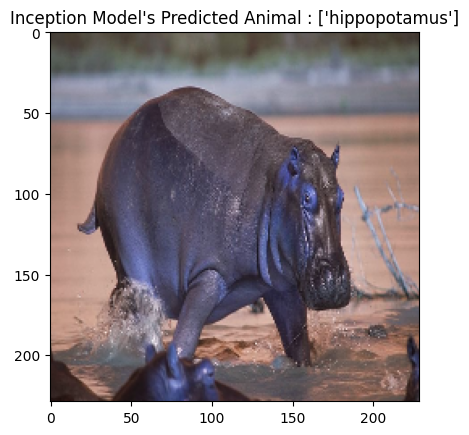

In [30]:
import numpy as np

n = np.random.randint(0,np.shape(test_images)[0])

plt.imshow(test_images[n])
plt.title("Inception Model's Predicted Animal : " + str(le.inverse_transform([inception_predictions[n]])))
plt.show()